In [81]:
# This cell checks if the required libraries are installed and installs them if they are not
import sys
import subprocess
import pkg_resources

required = {'yfinance', 'pandas', 'seaborn', 'matplotlib', 'pycaret', 'prophet'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)


In [82]:
# Part 1: Import Libraries
import datetime as dt
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from pycaret.regression import *
from tabulate import tabulate

In [83]:
# Part 2: Import Tickers
symbols_list = ["AUDJPY=X", "AUDUSD=X", "TIO=F", "EURUSD=X", "CAD=X", "CL=F", "HG=F", "ZT=F"]
start = dt.datetime(2011, 1, 1)
end = dt.datetime(2024, 4, 25)


In [84]:
# Part 3: Check Data
try:
    data = yf.download(symbols_list, start=start, end=end)
    print("Initial data check:")
    print(data.head())
except Exception as e:
    print("Failed to download data:", e)
    

[*********************100%%**********************]  8 of 8 completed

Initial data check:
Price       Adj Close                                                  \
Ticker       AUDJPY=X  AUDUSD=X    CAD=X       CL=F  EURUSD=X    HG=F   
Date                                                                    
2011-01-03  82.839996  1.021440  0.99270  91.550003  1.335791  4.4515   
2011-01-04  83.019997  1.016911  0.99239  89.379997  1.335684  4.3635   
2011-01-05  82.600403  1.007201  0.99700  90.300003  1.332108  4.4015   
2011-01-06  83.139999  0.999900  0.99650  88.379997  1.315686  4.3210   
2011-01-07  82.695000  0.993049  0.99750  88.029999  1.297993  4.2725   

Price                                   Close            ...        Open  \
Ticker           TIO=F        ZT=F   AUDJPY=X  AUDUSD=X  ...       TIO=F   
Date                                                     ...               
2011-01-03  170.000000  109.429688  82.839996  1.021440  ...  170.000000   
2011-01-04  172.070007  109.398438  83.019997  1.016911  ...  172.070007   
2011-01-05  174

Data after preprocessing:
Ticker      AUDJPY=X  AUDUSD=X     CAD=X      CL=F  EURUSD=X      HG=F  \
Date                                                                     
2011-01-04  0.002173 -0.004434 -0.000312 -0.023703 -0.000080 -0.019769   
2011-01-05 -0.005054 -0.009548  0.004645  0.010293 -0.002678  0.008709   
2011-01-06  0.006533 -0.007249 -0.000501 -0.021263 -0.012328 -0.018289   
2011-01-07 -0.005352 -0.006852  0.001003 -0.003960 -0.013447 -0.011224   
2011-01-10 -0.000723  0.002190 -0.005714  0.013859 -0.006538 -0.004213   

Ticker         TIO=F      ZT=F  
Date                            
2011-01-04  0.012177 -0.000286  
2011-01-05  0.014122 -0.002142  
2011-01-06 -0.005731  0.000930  
2011-01-07  0.000000  0.001502  
2011-01-10  0.000000  0.000500  


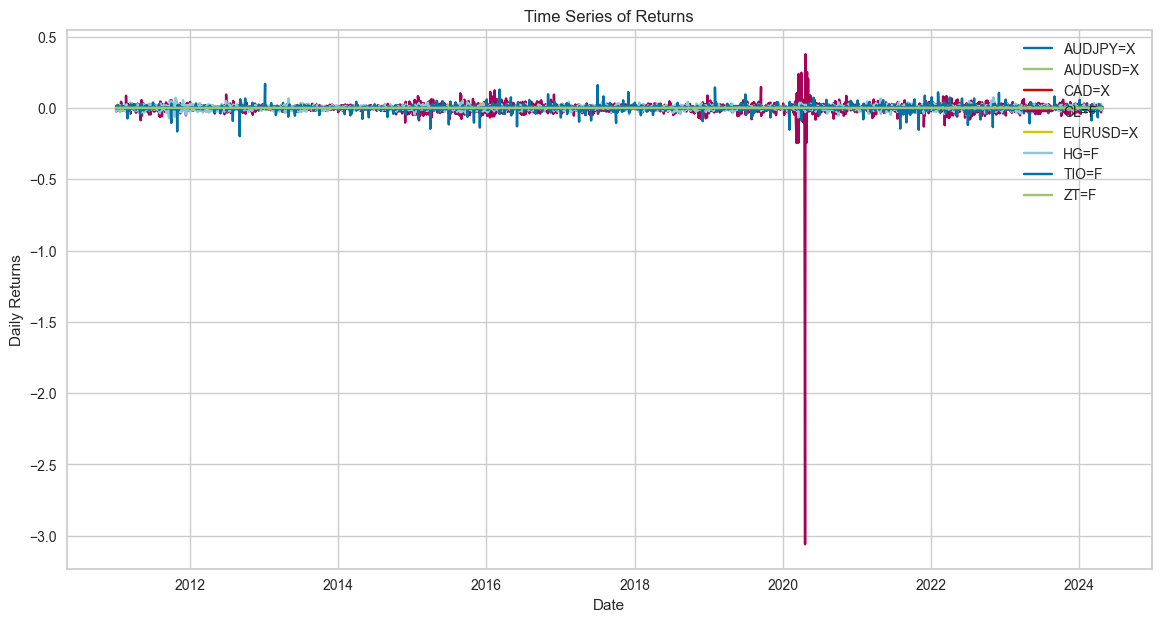

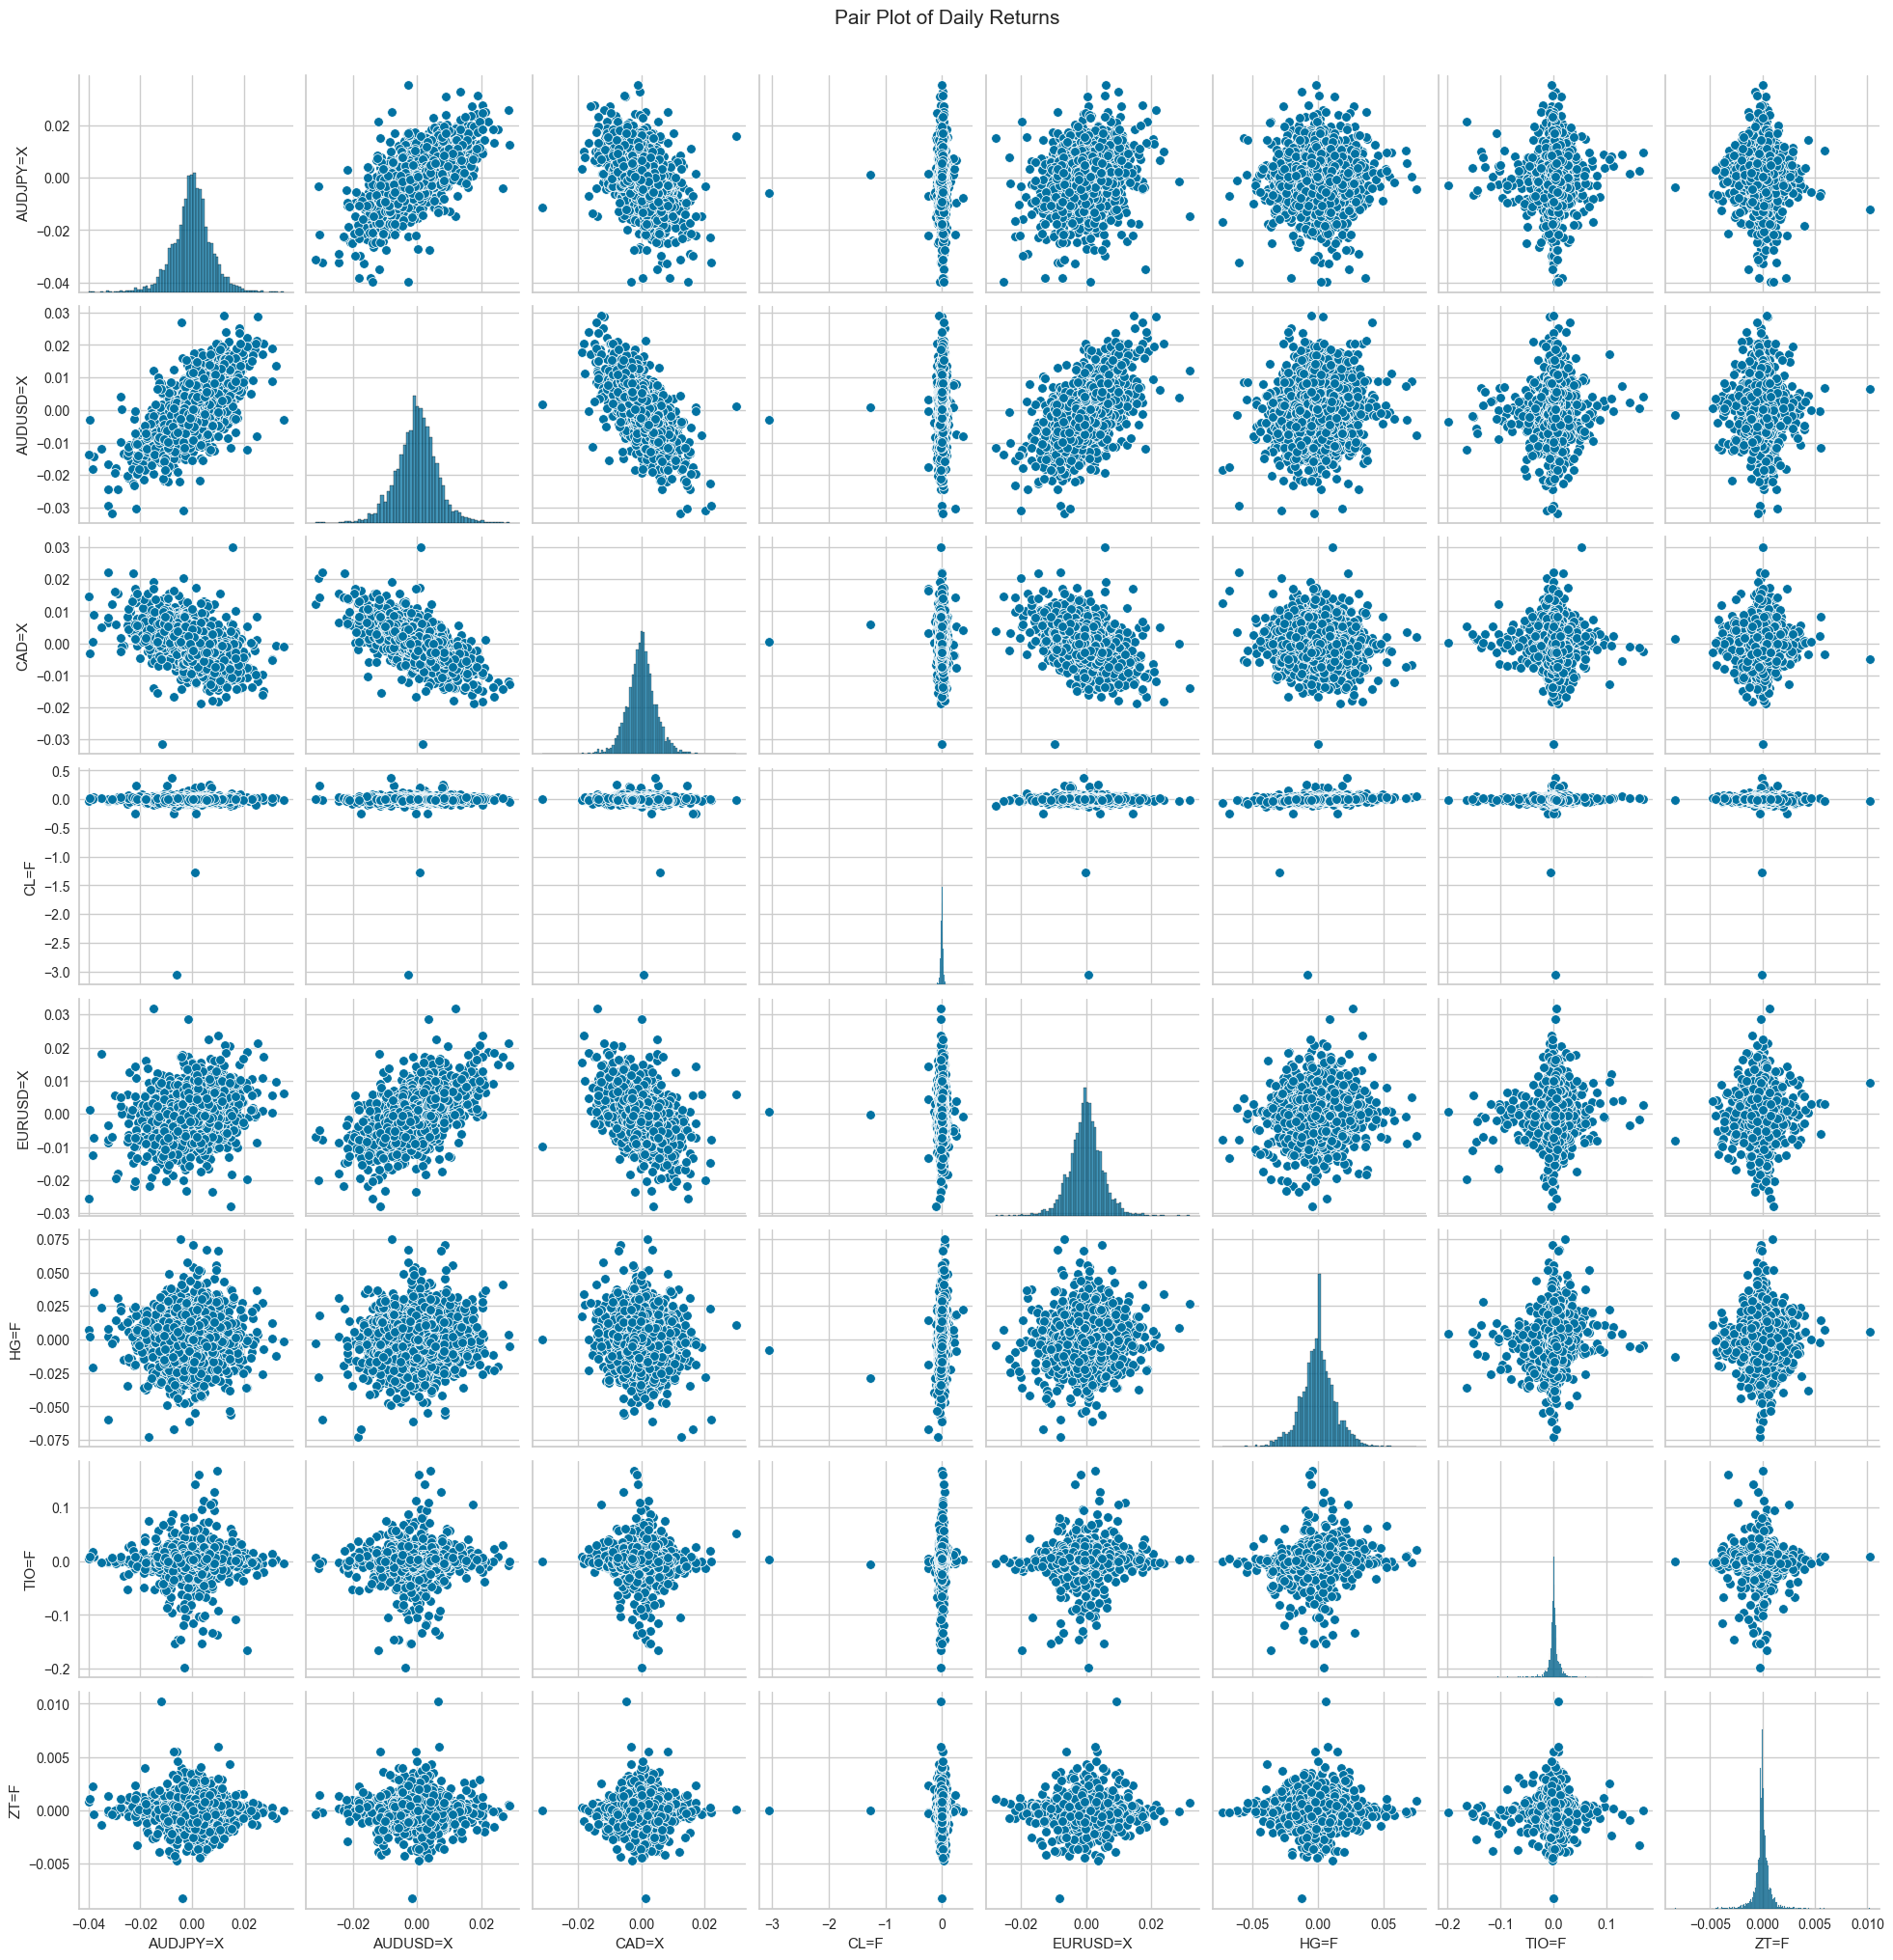

In [85]:
# Part 4: Prepare Data
# Keep only the adjusted close prices
adjusted_close = data['Adj Close']

# Calculate daily returns
returns = adjusted_close.pct_change()

# Drop rows with NaN values which might be present especially at the beginning
returns = returns.dropna()

# Quick data check after preprocessing
print("Data after preprocessing:")
print(returns.head())

# Visual Inspection of Returns
plt.figure(figsize=(14, 7))
for symbol in returns.columns:
    plt.plot(returns.index, returns[symbol], label=symbol)
plt.legend(loc='upper right')
plt.title('Time Series of Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

# Generating a pair plot of the returns to visually inspect correlations
sns.pairplot(returns)
plt.suptitle('Pair Plot of Daily Returns', size=15, y=1.02)
plt.show()


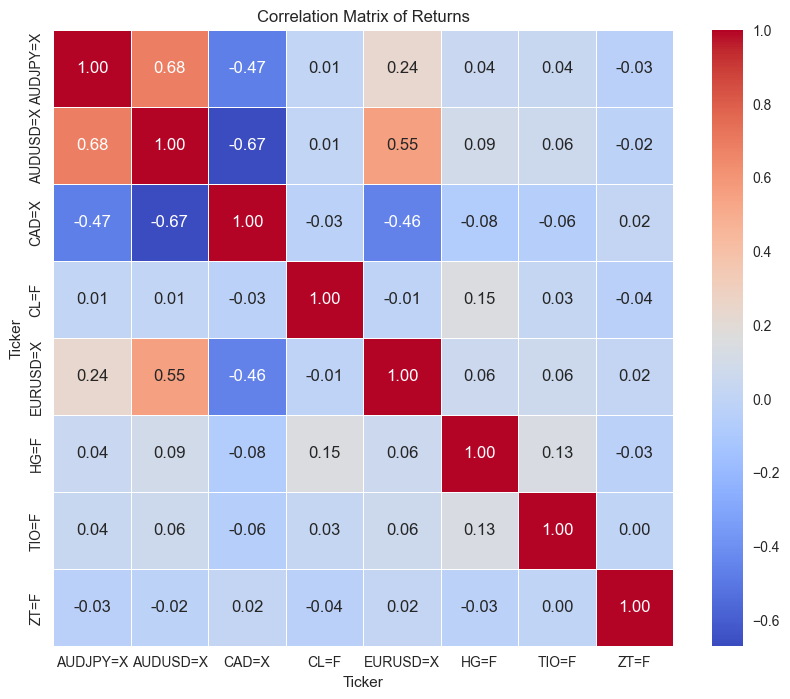

In [86]:
# Part 5: Compute and Visualize Correlation Matrix
correlation_matrix = returns.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Returns')
plt.show()


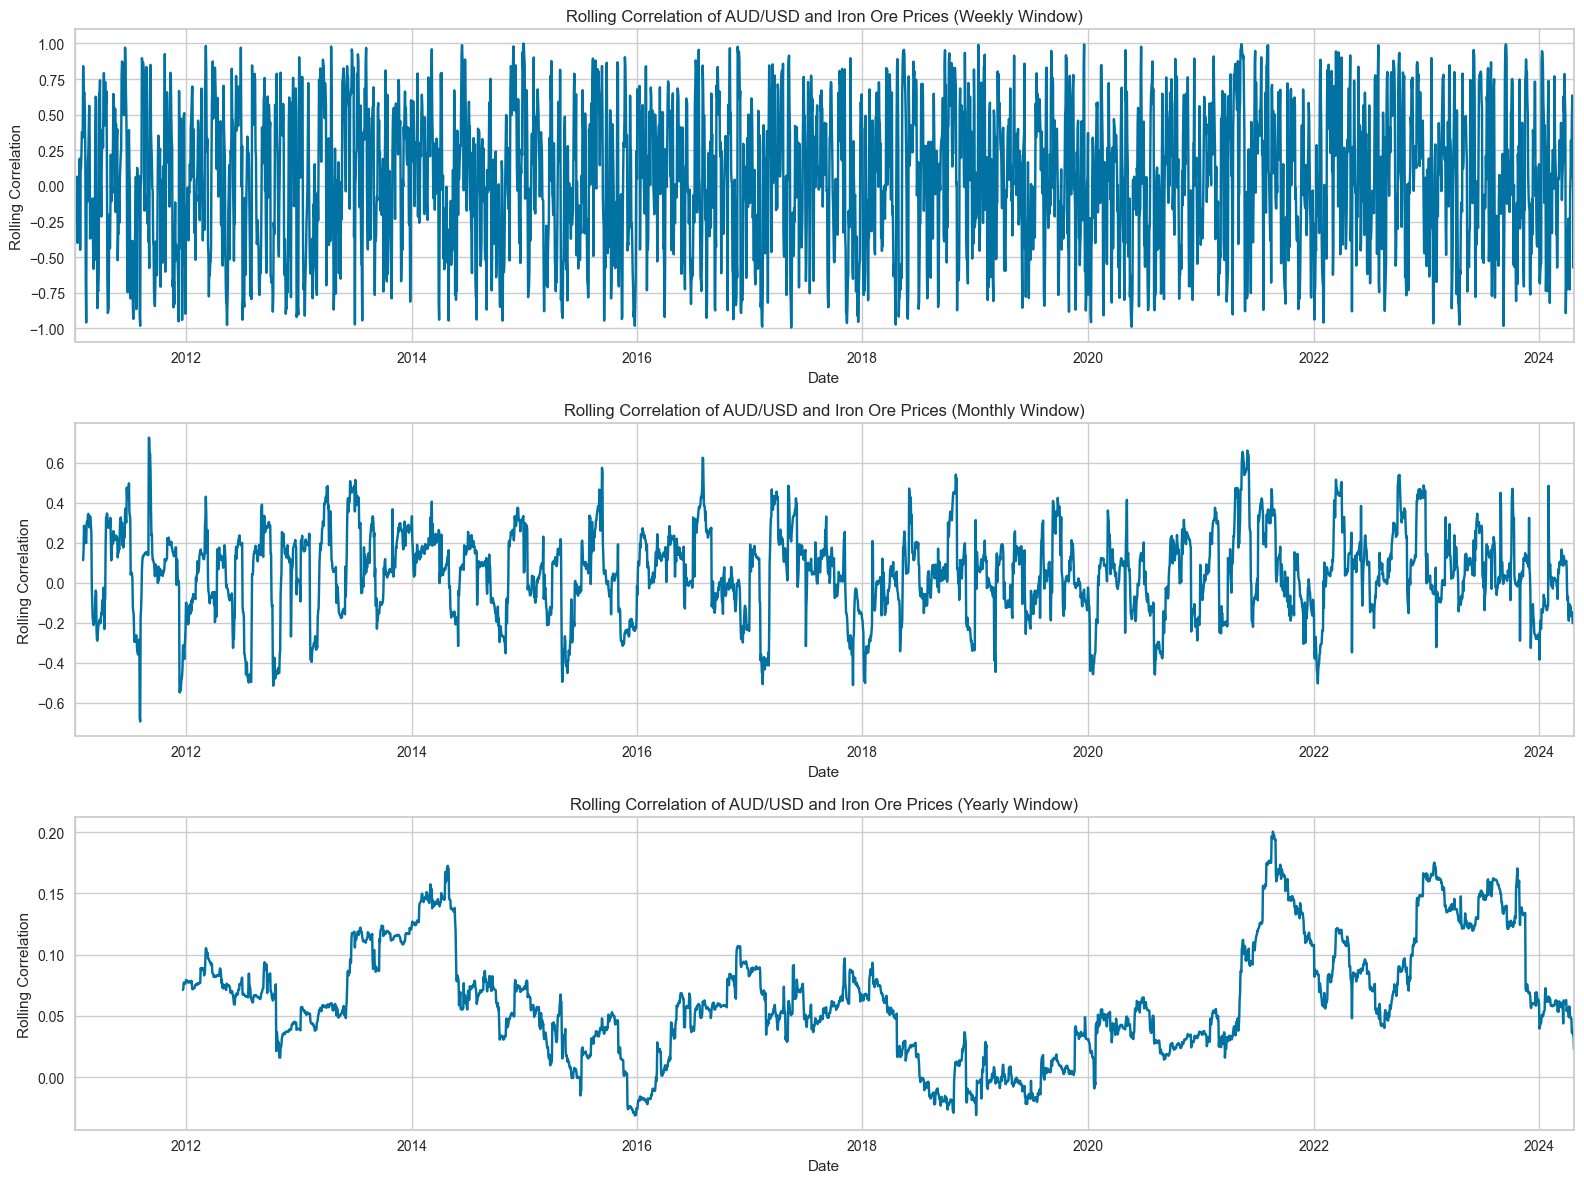

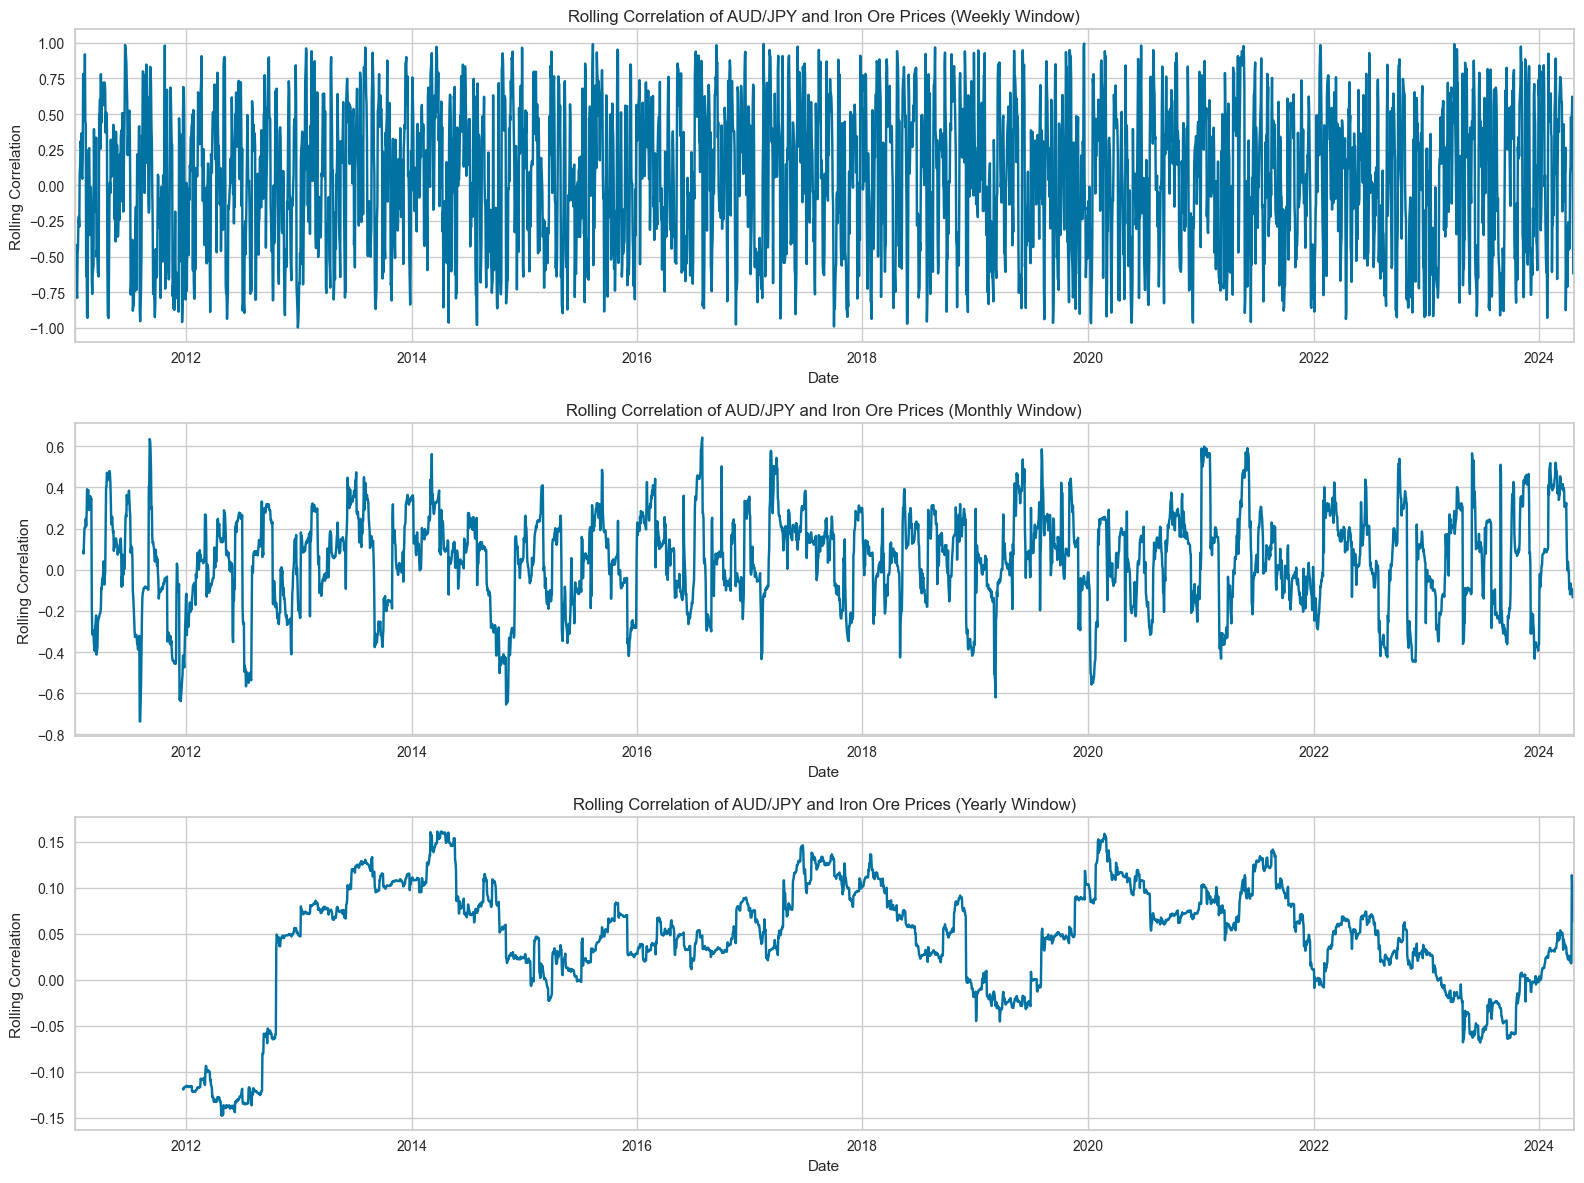

In [87]:
# Part 6: Calculate and Visualize Rolling Correlation Over Different Time Frames
# Extract AUD to Iron Ore returns
aud_returns = returns['AUDUSD=X']
iron_returns = returns['TIO=F']

# Define rolling windows: approximately 1 week (5 trading days), 1 month (21 trading days), and 1 year (252 trading days)
windows = {
    'Weekly': 5,
    'Monthly': 21,
    'Yearly': 252
}

# Calculate and plot rolling correlations for each window
plt.figure(figsize=(16, 12))
for i, (label, window) in enumerate(windows.items(), start=1):
    plt.subplot(3, 1, i)
    rolling_correlation = aud_returns.rolling(window=window).corr(iron_returns)
    rolling_correlation.plot()
    plt.title(f'Rolling Correlation of AUD/USD and Iron Ore Prices ({label} Window)')
    plt.xlabel('Date')
    plt.ylabel('Rolling Correlation')

plt.tight_layout()
plt.show()

# Do the Same with AUDJPY
audjpy_returns = returns['AUDJPY=X']
iron_returns = returns['TIO=F']
windows = {
    'Weekly': 5,
    'Monthly': 21,
    'Yearly': 252
}
plt.figure(figsize=(16, 12))
for i, (label, window) in enumerate(windows.items(), start=1):
    plt.subplot(3, 1, i)
    rolling_correlation = audjpy_returns.rolling(window=window).corr(iron_returns)
    rolling_correlation.plot()
    plt.title(f'Rolling Correlation of AUD/JPY and Iron Ore Prices ({label} Window)')
    plt.xlabel('Date')
    plt.ylabel('Rolling Correlation')

plt.tight_layout()
plt.show()

In [88]:
# Part 7: Optimize and Compare Models with PyCaret

# Add lagged features to the returns DataFrame
returns['Iron_Lag1'] = returns['TIO=F'].shift(1)
returns['Iron_Lag2'] = returns['TIO=F'].shift(2)
returns['Iron_Lag3'] = returns['TIO=F'].shift(3)

# Drop rows with NaN values
returns = returns.dropna()

# Features
features = ['Iron_Lag1', 'Iron_Lag2', 'Iron_Lag3']
target_audusd = 'AUDUSD=X'
target_audjpy = 'AUDJPY=X'

# Setup the PyCaret environment for AUDUSD
exp_audusd = setup(data=returns, 
                   target='AUDUSD=X', 
                   session_id=123, 
                   preprocess=True, 
                   ignore_features=['AUDJPY=X'], 
                   numeric_features=['Iron_Lag1', 'Iron_Lag2', 'Iron_Lag3'],
                   categorical_features=None, 
                   date_features=None, 
                   text_features=None, 
                   feature_selection=True)

# Compare models to find the best one for AUDUSD
best_model_audusd = compare_models(exclude=['ransac'], fold=5)

# Setup for AUDJPY
exp_audjpy = setup(data=returns, 
                   target='AUDJPY=X', 
                   session_id=123, 
                   preprocess=True, 
                   ignore_features=['AUDUSD=X'], 
                   numeric_features=['Iron_Lag1', 'Iron_Lag2', 'Iron_Lag3'],
                   categorical_features=None, 
                   date_features=None, 
                   text_features=None, 
                   feature_selection=True)

# Compare models to find the best one for AUDJPY
best_model_audjpy = compare_models(exclude=['ransac'], fold=5)

,Description,Value
0,Session id,123
1,Target,AUDUSD=X
2,Target type,Regression
3,Original data shape,"(3469, 11)"
4,Transformed data shape,"(3469, 2)"
5,Transformed train set shape,"(2428, 2)"
6,Transformed test set shape,"(1041, 2)"
7,Ignore features,1
8,Numeric features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0038,0.0000,0.0051,0.3813,0.0043,1.7698,0.2560
lar,Least Angle Regression,0.0038,0.0000,0.0051,0.3813,0.0043,1.7698,0.1000
omp,Orthogonal Matching Pursuit,0.0038,0.0000,0.0051,0.3813,0.0043,1.7698,0.1020
br,Bayesian Ridge,0.0038,0.0000,0.0051,0.3813,0.0043,1.7688,0.1040
huber,Huber Regressor,0.0038,0.0000,0.0051,0.3804,0.0043,1.8034,0.1100
ada,AdaBoost Regressor,0.0039,0.0000,0.0052,0.3654,0.0044,1.8464,0.1800
gbr,Gradient Boosting Regressor,0.0039,0.0000,0.0052,0.3631,0.0044,1.8809,0.2080
lightgbm,Light Gradient Boosting Machine,0.0040,0.0000,0.0052,0.3494,0.0043,2.1435,0.8560
knn,K Neighbors Regressor,0.0043,0.0000,0.0056,0.2627,0.0044,2.4145,0.1100
rf,Random Forest Regressor,0.0047,0.0000,0.0060,0.1399,0.0047,2.8084,0.2360


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2428, number of used features: 9
[LightGBM] [Info] Start training from score 0.000184


,Description,Value
0,Session id,123
1,Target,AUDJPY=X
2,Target type,Regression
3,Original data shape,"(3469, 11)"
4,Transformed data shape,"(3469, 2)"
5,Transformed train set shape,"(2428, 2)"
6,Transformed test set shape,"(1041, 2)"
7,Ignore features,1
8,Numeric features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0053,0.0001,0.0072,0.0594,0.0063,1.9262,0.1140
lar,Least Angle Regression,0.0053,0.0001,0.0072,0.0594,0.0063,1.9262,0.0880
omp,Orthogonal Matching Pursuit,0.0053,0.0001,0.0072,0.0594,0.0063,1.9262,0.0880
br,Bayesian Ridge,0.0053,0.0001,0.0072,0.0594,0.0063,1.9186,0.0840
huber,Huber Regressor,0.0053,0.0001,0.0072,0.0592,0.0063,1.9690,0.0900
ada,AdaBoost Regressor,0.0055,0.0001,0.0074,0.0122,0.0063,1.7929,0.1300
ridge,Ridge Regression,0.0055,0.0001,0.0074,0.0013,0.0072,1.1666,0.0880
gbr,Gradient Boosting Regressor,0.0055,0.0001,0.0074,-0.0008,0.0063,2.0701,0.1580
par,Passive Aggressive Regressor,0.0055,0.0001,0.0074,-0.0039,0.0074,1.0000,0.0860
lightgbm,Light Gradient Boosting Machine,0.0056,0.0001,0.0075,-0.0048,0.0061,2.6620,1.0400


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing


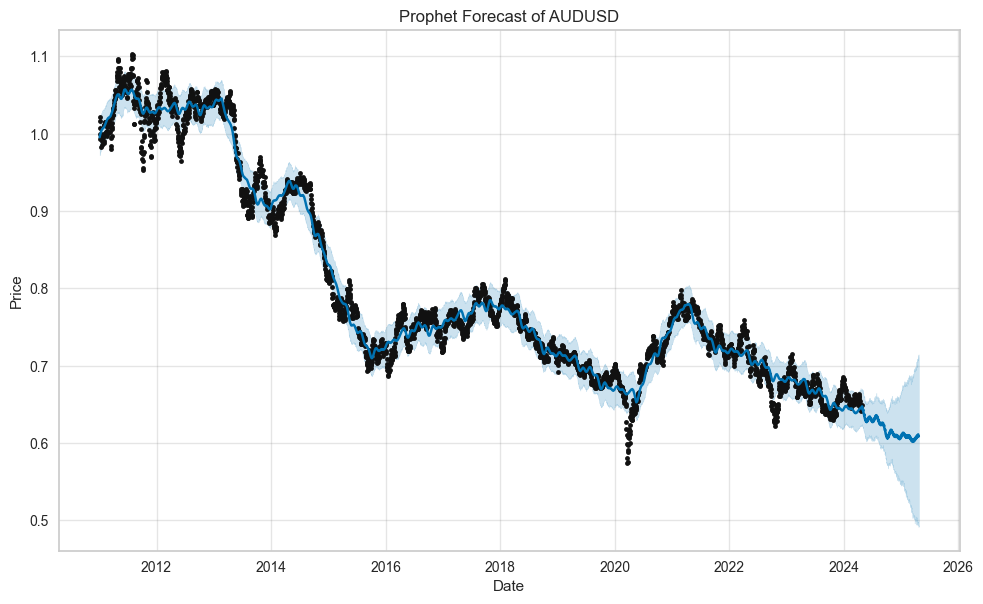

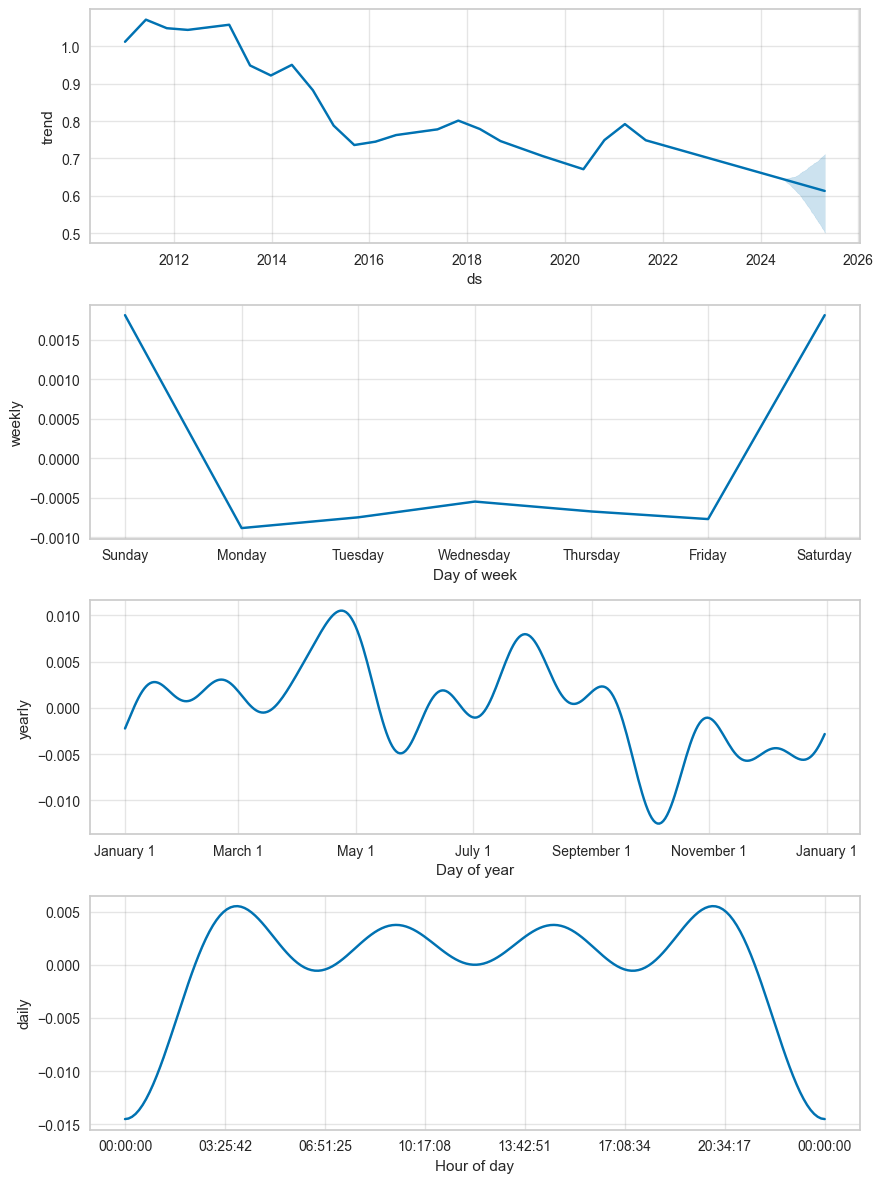

In [89]:
# Part 8: Forecasting Future Prices Using Prophet

# Preparing data for Prophet
prophet_df = data['Adj Close'][['AUDUSD=X']].reset_index()
prophet_df.columns = ['ds', 'y']

# Initializing and fitting the model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Making future dataframe for predictions
future = model.make_future_dataframe(periods=365)  # Predicting the next year
forecast = model.predict(future)

# Plotting the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast of AUDUSD')
plt.ylabel('Price')
plt.xlabel('Date')

# Plotting components
fig2 = model.plot_components(forecast)


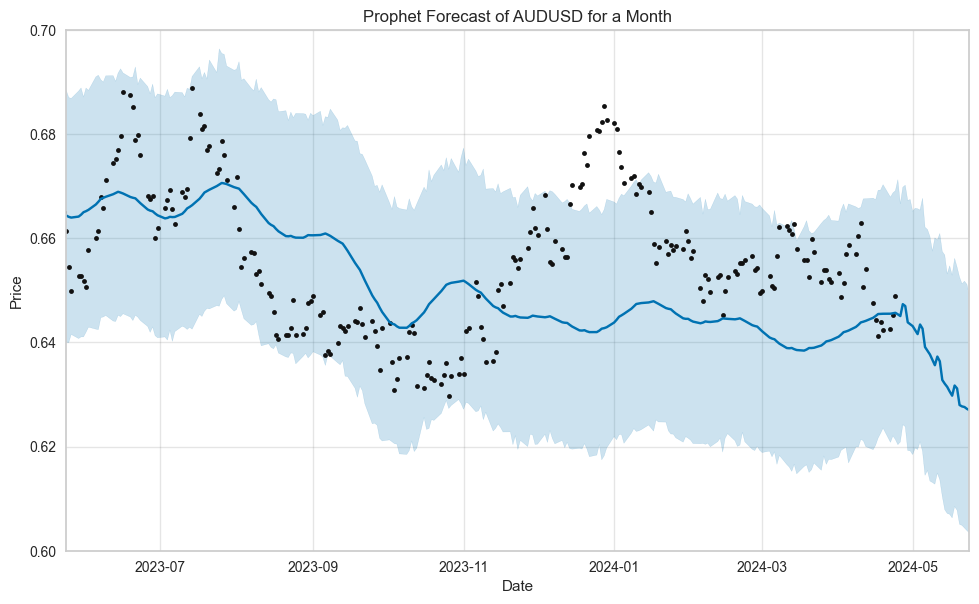

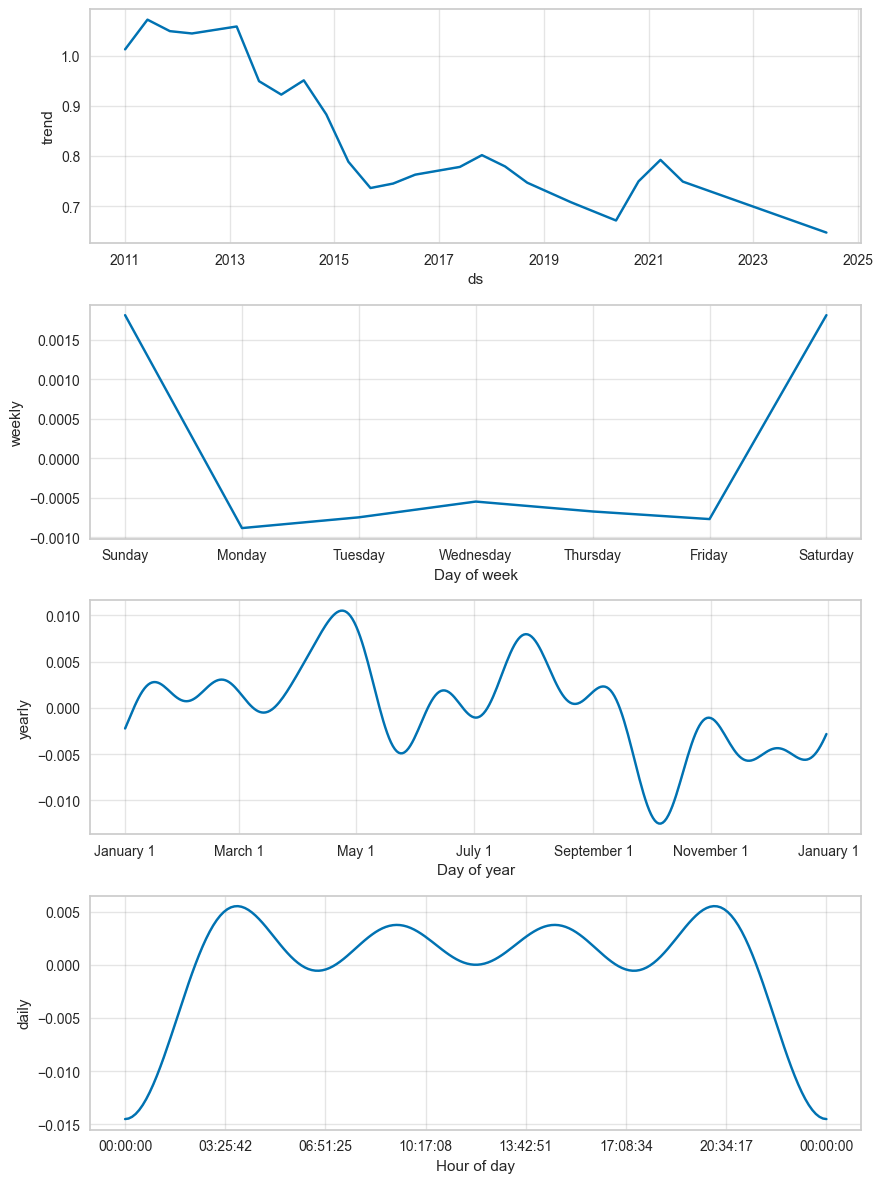

In [90]:
# Making future dataframe for predictions
# Predicting for a month (30 days)
future_month = model.make_future_dataframe(periods=30)
forecast_month = model.predict(future_month)

# Plotting the forecast for a month
fig1_month = model.plot(forecast_month)
plt.title('Prophet Forecast of AUDUSD for a Month')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xlim(forecast_month['ds'].max() - pd.DateOffset(months=12), forecast_month['ds'].max())
plt.ylim(0.6,0.7)

# Plotting components
fig2 = model.plot_components(forecast_month)

16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:28:29 - cmdstanpy - INFO - Chain [1] done processing


(0.63, 0.66)

<Figure size 1000x600 with 0 Axes>

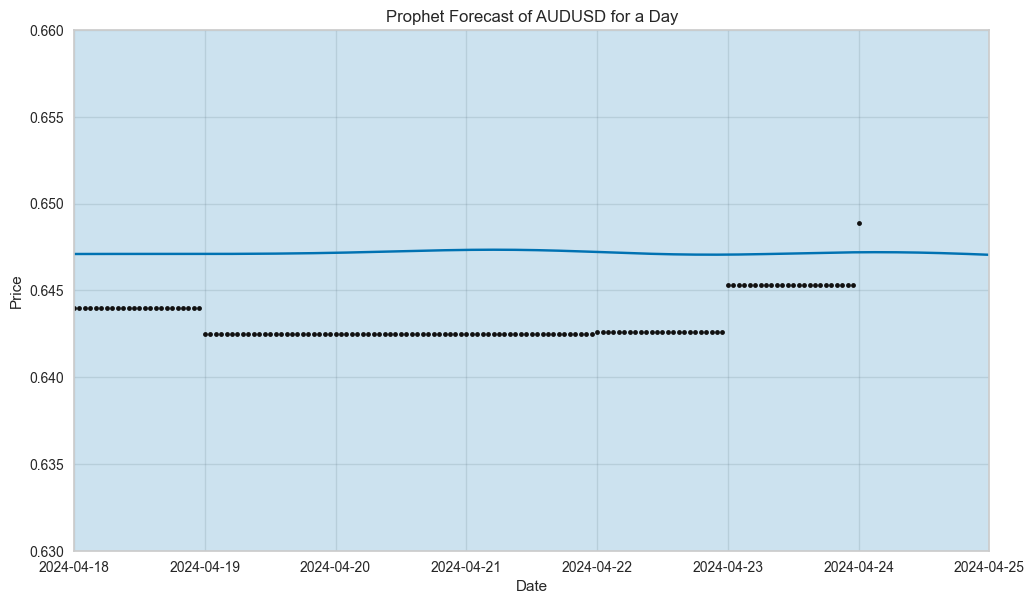

In [91]:
# Preparing data for Prophet with hourly frequency
prophet_df_hourly = data['Adj Close'][['AUDUSD=X']].resample('H').ffill().reset_index()
prophet_df_hourly.columns = ['ds', 'y']

# Initializing and fitting the model for hourly data
model_hourly = Prophet(daily_seasonality=False)  # Since we're using hourly data, disable daily seasonality
model_hourly.fit(prophet_df_hourly)

# Making future dataframe for hourly predictions for the next day
future_hourly = model_hourly.make_future_dataframe(periods=1*24, freq='H')  # Predicting the next dat with hourly frequency
forecast_hourly = model_hourly.predict(future_hourly)

# Plotting the forecast for the next day with hourly frequency
plt.figure(figsize=(10, 6))
fig_day_hourly = model_hourly.plot(forecast_hourly)
plt.title('Prophet Forecast of AUDUSD for a Day')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xlim(forecast_hourly['ds'].max() - pd.DateOffset(days=7), forecast_hourly['ds'].max())
plt.ylim(0.63,0.66)

In [92]:
# Cell #9: Calculate Daily Changes and Identify Significant Downward Moves in Iron Ore (Display in Standard Deviations)

# Calculate daily changes for Iron Ore
returns['Iron_Ore_Daily_Change'] = returns['TIO=F'].diff()
daily_change_std = returns['Iron_Ore_Daily_Change'].std()
daily_change_mean = returns['Iron_Ore_Daily_Change'].mean()

# Calculate the threshold for significant moves (1.5 STD below the mean)
threshold_down = daily_change_mean - 1.5 * daily_change_std

# Identify days where Iron Ore moved significantly below the mean
significant_down_moves = returns[returns['Iron_Ore_Daily_Change'] <= threshold_down]

# Calculate how many standard deviations below the mean each significant move is
significant_down_moves['Std_Devs_Below_Mean'] = (significant_down_moves['Iron_Ore_Daily_Change'] - daily_change_mean) / daily_change_std

# Display the threshold and a sample of significant moves with standard deviations
print("Threshold for significant downward move (1.5 STD below mean):", -1.5)
print("Sample of significant downward moves in Iron Ore (in standard deviations):")
print(significant_down_moves[['Iron_Ore_Daily_Change', 'Std_Devs_Below_Mean']].head())


Threshold for significant downward move (1.5 STD below mean): -1.5
Sample of significant downward moves in Iron Ore (in standard deviations):
Ticker      Iron_Ore_Daily_Change  Std_Devs_Below_Mean
Date                                                  
2011-03-01              -0.071805            -3.062554
2011-04-01              -0.038733            -1.651997
2011-05-02              -0.046748            -1.993861
2011-05-11              -0.040409            -1.723495
2011-07-06              -0.038241            -1.631043


In [93]:
# Cell #10: Extract Corresponding AUDUSD and AUDJPY Moves in Standard Deviations on Significant Down Days

# Extract corresponding AUDUSD and AUDJPY moves
audusd_moves = returns.loc[significant_down_moves.index, 'AUDUSD=X']
audjpy_moves = returns.loc[significant_down_moves.index, 'AUDJPY=X']

# Calculate moves in standard deviations from their means
audusd_std_devs = (audusd_moves - returns['AUDUSD=X'].mean()) / returns['AUDUSD=X'].std()
audjpy_std_devs = (audjpy_moves - returns['AUDJPY=X'].mean()) / returns['AUDJPY=X'].std()

# Display extracted currency moves for verification
print("Corresponding AUDUSD Moves on Significant Iron Ore Down Days (in standard deviations):")
print(audusd_std_devs.head())
print("Corresponding AUDJPY Moves on Significant Iron Ore Down Days (in standard deviations):")
print(audjpy_std_devs.head())



Corresponding AUDUSD Moves on Significant Iron Ore Down Days (in standard deviations):
Date
2011-03-01    0.665951
2011-04-01    0.236186
2011-05-02    0.315104
2011-05-11    0.683112
2011-07-06   -0.745088
Name: AUDUSD=X, dtype: float64
Corresponding AUDJPY Moves on Significant Iron Ore Down Days (in standard deviations):
Date
2011-03-01    1.038635
2011-04-01    0.485777
2011-05-02   -0.251066
2011-05-11    1.819841
2011-07-06   -0.128893
Name: AUDJPY=X, dtype: float64


In [94]:
# Cell #11: Calculate Statistical Metrics and Create Formatted Summary Table in Standard Deviations

# Calculate the standard deviations for AUDUSD and AUDJPY on significant days
std_dev_audusd = audusd_std_devs.std()
std_dev_audjpy = audjpy_std_devs.std()

# Calculate mean and median of the standard deviations
mean_std_dev_audusd = audusd_std_devs.mean()
median_std_dev_audusd = audusd_std_devs.median()
mean_std_dev_audjpy = audjpy_std_devs.mean()
median_std_dev_audjpy = audjpy_std_devs.median()

# Determine percentage of moves in the same direction (both currencies and iron ore down)
same_direction_percentage_audusd = 100 * (audusd_std_devs[significant_down_moves['Iron_Ore_Daily_Change'] < 0] < 0).mean()
same_direction_percentage_audjpy = 100 * (audjpy_std_devs[significant_down_moves['Iron_Ore_Daily_Change'] < 0] < 0).mean()

# Create summary table data
summary_data = [
    ['AUDUSD', std_dev_audusd, mean_std_dev_audusd, median_std_dev_audusd, same_direction_percentage_audusd],
    ['AUDJPY', std_dev_audjpy, mean_std_dev_audjpy, median_std_dev_audjpy, same_direction_percentage_audjpy]
]

# Define table headers
headers = ['Currency Pair', 'Std Dev of Moves', 'Mean Std Devs', 'Median Std Devs', 'Percentage Moves Same Direction on Down Days']

# Format the table using tabulate
formatted_table = tabulate(summary_data, headers=headers, tablefmt='simple_grid', floatfmt=".4f")

# Display the formatted table
print("Summary of Currency Movements Relative to Significant Iron Ore Down Moves (in standard deviations):")
print(formatted_table)



Summary of Currency Movements Relative to Significant Iron Ore Down Moves (in standard deviations):
┌─────────────────┬────────────────────┬─────────────────┬───────────────────┬────────────────────────────────────────────────┐
│ Currency Pair   │   Std Dev of Moves │   Mean Std Devs │   Median Std Devs │   Percentage Moves Same Direction on Down Days │
├─────────────────┼────────────────────┼─────────────────┼───────────────────┼────────────────────────────────────────────────┤
│ AUDUSD          │             1.1252 │          0.0153 │           -0.0139 │                                        50.7692 │
├─────────────────┼────────────────────┼─────────────────┼───────────────────┼────────────────────────────────────────────────┤
│ AUDJPY          │             1.1001 │         -0.0075 │           -0.0497 │                                        52.3077 │
└─────────────────┴────────────────────┴─────────────────┴───────────────────┴────────────────────────────────────────────────┘


In [95]:
# Cell #12 Analyze Movements in Standard Deviations for First 6 Symbols on Significant Iron Ore Down Days

# Prepare a list to store DataFrames for each symbol
symbol_dfs = []

# Select the first 6 symbols in the returns DataFrame
symbols = returns.columns.drop('TIO=F')[:7]  # Exclude Iron Ore itself and select first 6 symbols

# Loop through each selected symbol
for symbol in symbols:
    # Extract the returns for the symbol on the significant Iron Ore move days
    symbol_moves = returns.loc[significant_down_moves.index, symbol]
    
    # Calculate the moves in terms of standard deviations from the mean of daily returns
    symbol_mean = returns[symbol].mean()
    symbol_std = returns[symbol].std()
    symbol_std_devs = (symbol_moves - symbol_mean) / symbol_std
    
    # Calculate mean and median of these standard deviation movements
    std_dev_mean = symbol_std_devs.mean()
    std_dev_median = symbol_std_devs.median()
    
    # Calculate the percentage of days the symbol moved in the same direction as Iron Ore
    same_direction_moves = (symbol_moves < 0) == (returns.loc[significant_down_moves.index, 'TIO=F'] < 0)
    moves_in_same_direction_percent = 100 * same_direction_moves.mean()

    # Create a DataFrame for current symbol results
    symbol_df = pd.DataFrame({
        'Symbol': [symbol],
        'Mean Std Devs': [std_dev_mean],
        'Median Std Devs': [std_dev_median],
        'Percentage Moves Same Direction': [moves_in_same_direction_percent]
    })

    # Append DataFrame to the list
    symbol_dfs.append(symbol_df)

# Concatenate all DataFrames into a single DataFrame
symbols_std_dev_analysis = pd.concat(symbol_dfs, ignore_index=True)

# Format the summary table using tabulate for better readability
formatted_table = tabulate(symbols_std_dev_analysis, headers='keys', tablefmt='grid', floatfmt='.4f')

# Display the formatted summary table
print("Summary of Symbol Movements in Standard Deviations Relative to Significant Iron Ore Down Moves:")
print(formatted_table)


Summary of Symbol Movements in Standard Deviations Relative to Significant Iron Ore Down Moves:
+----+----------+-----------------+-------------------+-----------------------------------+
|    | Symbol   |   Mean Std Devs |   Median Std Devs |   Percentage Moves Same Direction |
+====+==========+=================+===================+===================================+
|  0 | AUDJPY=X |         -0.0075 |           -0.0497 |                           49.2308 |
+----+----------+-----------------+-------------------+-----------------------------------+
|  1 | AUDUSD=X |          0.0153 |           -0.0139 |                           53.8462 |
+----+----------+-----------------+-------------------+-----------------------------------+
|  2 | CAD=X    |         -0.0568 |           -0.0551 |                           50.0000 |
+----+----------+-----------------+-------------------+-----------------------------------+
|  3 | CL=F     |         -0.0092 |            0.0121 |                     